In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
device = torch.device('cpu')

In [2]:
import sys
sys.path.append("../")
from model import YModel
from utils import sample_noise, iterate_minibatches, generate_local_data, generate_local_data_lhs
from optim import find_psi, InputOptimisation, make_figures
from utils import DistPlotter
from IPython.display import clear_output
import numpy as np
import torch

In [3]:
psi_init = torch.tensor([[7., 5.],
                         [6., 6.],
                         [6., 6.]])

In [4]:
ymodel = YModel(psi_init=psi_init[0], device=device)

In [5]:
%%time
hessian = ymodel.grad(psi_init, num_repetitions=10000)

CPU times: user 272 ms, sys: 32 ms, total: 304 ms
Wall time: 98.5 ms


In [6]:
hessian

tensor([[0.0115, 0.0082],
        [0.0079, 0.0079],
        [0.0088, 0.0088]])

In [7]:
hessian.sum(axis=0)

tensor([0.0282, 0.0249])

In [8]:
hessian[0] * 3

tensor([0.0345, 0.0247])

In [11]:
ymodel.grad(psi_init[2], num_repetitions=100000)

tensor([0.0089, 0.0089])

In [20]:
from scipy.spatial.distance import cosine

In [30]:
cosine(eigvecs, eigvecs)

ValueError: Input vector should be 1-D.

In [26]:
eigvecs[:, 0]

array([-0.89442724,  0.44721344], dtype=float32)

In [22]:
np.linalg.svd(hessian)

(array([[-0.89442724,  0.44721344],
        [ 0.44721344,  0.89442724]], dtype=float32),
 array([0.01108169, 0.00110066], dtype=float32),
 array([[ 0.89442724, -0.44721344],
        [-0.44721344, -0.89442724]], dtype=float32))

In [ ]:
from ffjord_model import FFJORDModel

In [12]:
torch.linspace(psi_init - 1, psi_init + 1, 1000)

TypeError: linspace(): argument 'start' (position 1) must be Number, not Tensor

In [4]:
model = FFJORDModel(dim_x=1, dim_condition=3).to(device)

In [21]:
torch.isfinite()).all()dd

tensor(1, dtype=torch.uint8)

In [19]:
torch.isfinite

<function torch.functional.isfinite(tensor)>

In [22]:
import sys

def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

In [24]:
model_cls = str_to_class('FFJORDModel')

In [25]:
from collections import namedtuple


In [76]:
make_model = lambda : build_model_tabular(dims=1, 
                            condition_dim=3,
                            layer_type='concat_v2',
                            num_blocks=3,
                            rademacher=False,
                            nonlinearity='tanh',
                            solver='rk4',
                            hidden_dims=(32, 32),
                            bn_lag=0.01, 
                            batch_norm=True,
                            regularization_fns=None).to(device)

In [77]:
x = torch.randn(10, 1).to(device)
y = torch.randn(10, 3).to(device)

In [4]:
from hessian import jacobian, gradient, power_method, rayleigh_quotient

In [5]:
def find_psi(device, NOISE_DIM, io_model, y_sampler, init_mu, lr=50., average_size=1000, n_iter=10000, use_true=False):
    mu_optim_original = init_mu[0].clone().detach().to(device)
    mu_optim_original.requires_grad = True    

    losses = []
    m_vals = []
    for _iter in range(n_iter):
        noise = torch.Tensor(sample_noise(average_size, NOISE_DIM)).to(device)
        mu_optim = mu_optim_original.repeat(average_size, 1)
        x = y_sampler.x_dist.sample([average_size, 1]).to(device)
        # Do an update
        if use_true:
            y_sampler.make_condition_sample({"mu": mu_optim, "X": x})
            data_gen = y_sampler.condition_sample()
        else:
            data_gen = io_model(noise, torch.cat([mu_optim, x], dim=1))
            #data_gen = io_model(torch.cat([mu_optim, x], dim=1))
        loss = OptLoss.SigmoidLoss(data_gen, 5, 10).mean()
        losses.append(loss.item())
        io_model.zero_grad()
        
        # loss.backward(retain_graph=True)
        hessian = hessian_calc(loss, mu_optim_original) + 1e-1 * torch.diag(torch.ones(len(mu_optim_original))).float().to(device)
        print(hessian, torch.det(hessian), np.linalg.cond(hessian.detach().cpu().numpy()))
        # hessian_inv = torch.inverse(hessian)
        loss.backward()
        grad = np.linalg.lstsq(hessian.detach().cpu().numpy(), mu_optim_original.grad.detach().cpu().numpy())[0]
        with torch.no_grad():
            mu_optim_original -= lr * torch.tensor(grad).float().to(device)
            mu_optim_original.grad.zero_()
            
        m_vals.append(mu_optim_original.detach().cpu().numpy())
    m_vals = np.array(m_vals)
    return m_vals, losses

In [6]:
n_samples_per_dim = 2000
grad_step = 2.
n_lhc_samples = 5

In [7]:
def train_flow(model, data, inputs):

        
    return model

In [8]:
optim_epochs = 5000

In [9]:
class InputOptimisation(nn.Module):
    def __init__(self, generator_model):
        super().__init__()
        self.gen = generator_model

    def forward(self, noise, inputs):
        return self.gen(noise, inputs)

In [10]:
def end_to_end_training(current_psi):
    r_values = []
    psi_values = [current_psi.detach().cpu().numpy()[0]]
    x_dim = 1
    try:
        total_epoch_counter = [0]
        for optim_epoch in range(optim_epochs): 
            print(optim_epoch)
            generator = make_model()
            data, inputs = generate_local_data_lhs(y_sampler, device,
                                                   n_samples_per_dim=n_samples_per_dim,
                                                   step=grad_step,
                                                   current_psi=current_psi, 
                                                   x_dim=x_dim,
                                                   n_samples=n_lhc_samples)
            generator = train_flow(generator, data, inputs)
            generator.eval()
            sample_fn, density_fn = get_transforms(generator)
            io_model = InputOptimisation(sample_fn)             
            psi_vals, losses = find_psi(device, 
                                        x_dim, 
                                        io_model, 
                                        y_sampler, 
                                        current_psi,
                                        lr=1., average_size=1000, n_iter=1, use_true=False)

            current_psi = torch.Tensor(psi_vals)
            psi_values.append(psi_vals[0])
            r_values.append(losses[0])
            
            if optim_epoch % 5 == 0:
                clear_output()
            
            print(np.array(psi_values))
            f = make_figures(r_values, np.array(psi_values))
            plt.show()

            n_psi = 200
            average_size = 1000
            fixed_noise = torch.Tensor(sample_noise(n_psi * average_size, x_dim)).to(device)

            dist_plotter = DistPlotter(y_sampler, sample_fn, fixed_noise, device, mu_dim=2)
            f, g = dist_plotter.draw_grads_and_losses(current_psi.view(-1),
                                                      psi_size=n_psi, 
                                                      average_size=average_size,
                                                      step=grad_step)
            torch.cuda.empty_cache()
            plt.show()
            
    except KeyboardInterrupt:
        pass

[[0.         0.        ]
 [0.02924292 0.13046396]
 [0.03330737 0.10741263]
 [0.09180087 0.18464291]
 [0.14991601 0.17653407]
 [0.17529918 0.1302451 ]
 [0.25900552 0.2093117 ]
 [0.26734152 0.24900651]
 [0.32630357 0.17289859]
 [0.51867867 0.18559684]
 [0.6478492  0.24308625]
 [0.835222   0.21648693]
 [0.9885143  0.24796456]
 [1.2142577  0.33420703]
 [1.3316116  0.49215934]
 [1.4992555  0.64011824]
 [1.7159973  0.69170314]
 [1.9844192  0.7604006 ]
 [2.2813575  0.84963596]
 [2.458073   0.9468842 ]
 [2.6770906  1.027783  ]
 [2.990252   1.1169047 ]
 [3.2067134  1.2072624 ]
 [3.487175   1.2858734 ]
 [3.6768088  1.3792646 ]
 [3.9456573  1.4992383 ]
 [4.1818132  1.5927382 ]
 [4.3904595  1.7345159 ]
 [4.6902404  1.8181981 ]
 [4.89608    1.9365873 ]
 [4.945859   1.8045512 ]
 [5.14453    1.9169822 ]
 [5.337231   1.9100585 ]
 [5.44042    1.963281  ]
 [5.517358   1.9809289 ]
 [5.7002525  2.07894   ]
 [5.8596168  2.1566825 ]
 [5.9985576  2.2268476 ]
 [6.0754166  2.3348663 ]
 [6.126794   2.2771788 ]


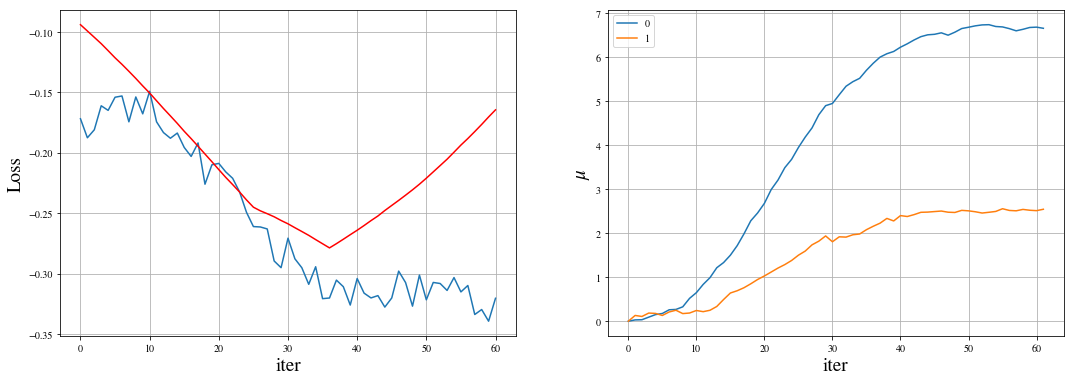

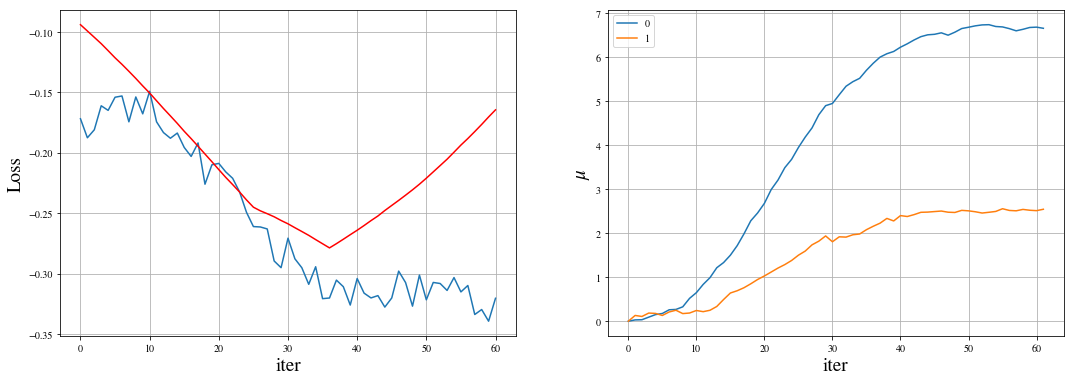

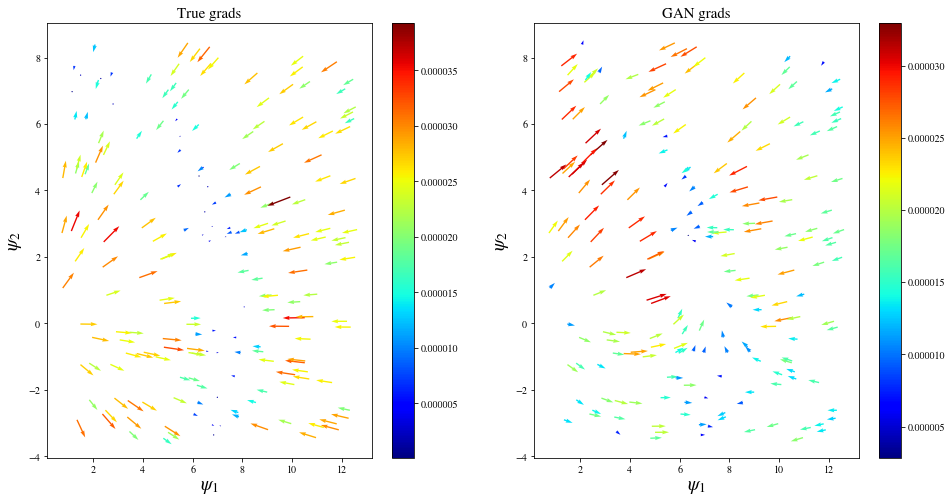

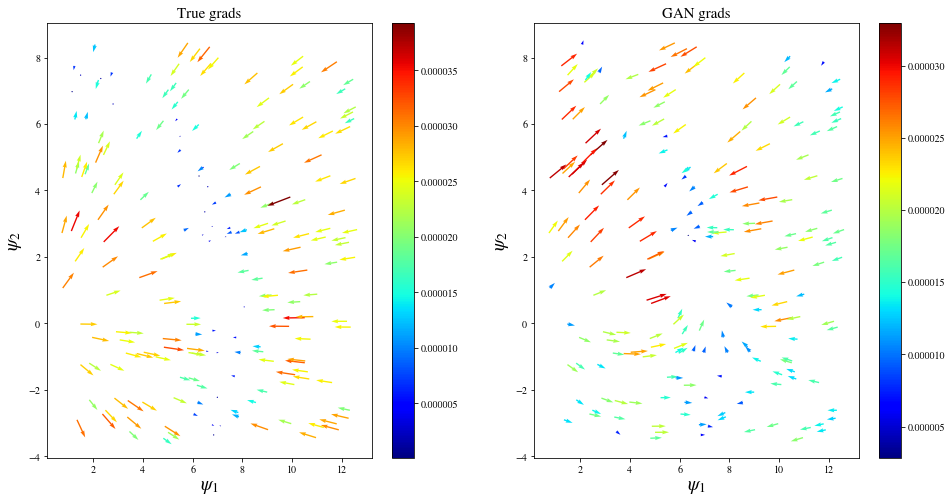

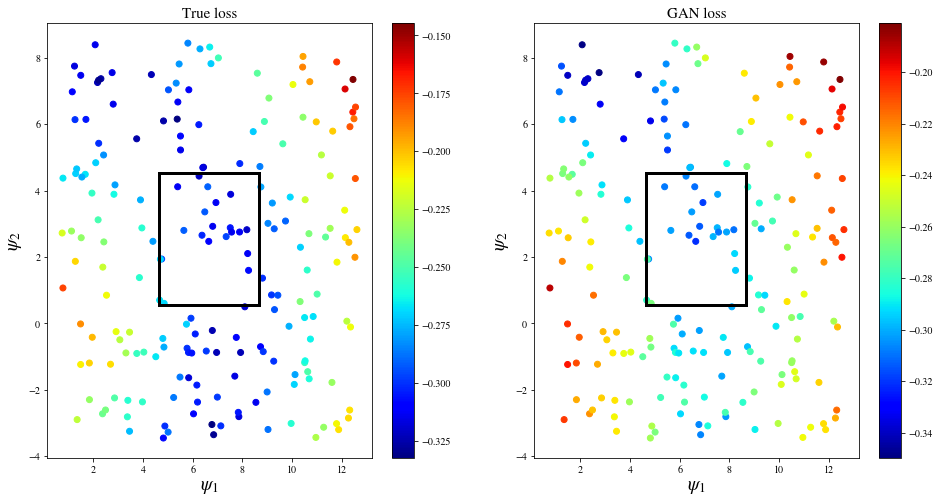

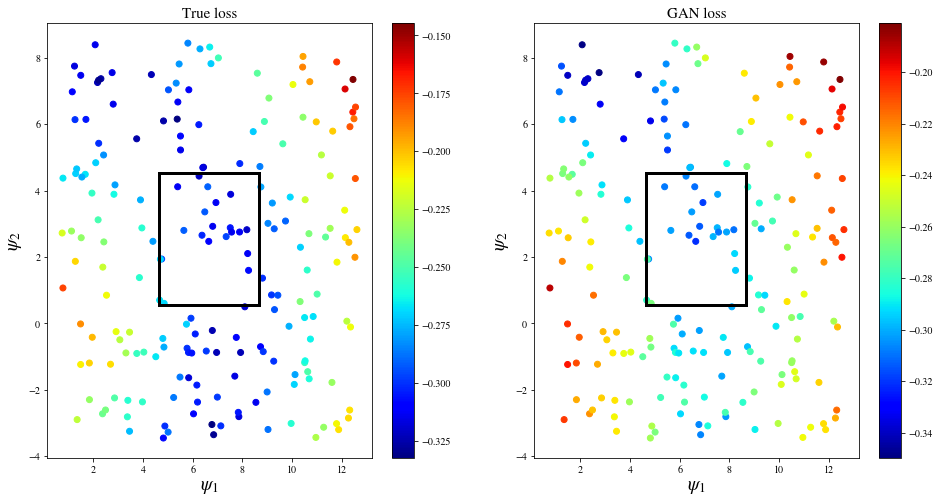

61
61
tensor(0.0113, device='cuda:2') 1.0692353
[ 0.07158479 -0.04294575]
[[0.         0.        ]
 [0.02924292 0.13046396]
 [0.03330737 0.10741263]
 [0.09180087 0.18464291]
 [0.14991601 0.17653407]
 [0.17529918 0.1302451 ]
 [0.25900552 0.2093117 ]
 [0.26734152 0.24900651]
 [0.32630357 0.17289859]
 [0.51867867 0.18559684]
 [0.6478492  0.24308625]
 [0.835222   0.21648693]
 [0.9885143  0.24796456]
 [1.2142577  0.33420703]
 [1.3316116  0.49215934]
 [1.4992555  0.64011824]
 [1.7159973  0.69170314]
 [1.9844192  0.7604006 ]
 [2.2813575  0.84963596]
 [2.458073   0.9468842 ]
 [2.6770906  1.027783  ]
 [2.990252   1.1169047 ]
 [3.2067134  1.2072624 ]
 [3.487175   1.2858734 ]
 [3.6768088  1.3792646 ]
 [3.9456573  1.4992383 ]
 [4.1818132  1.5927382 ]
 [4.3904595  1.7345159 ]
 [4.6902404  1.8181981 ]
 [4.89608    1.9365873 ]
 [4.945859   1.8045512 ]
 [5.14453    1.9169822 ]
 [5.337231   1.9100585 ]
 [5.44042    1.963281  ]
 [5.517358   1.9809289 ]
 [5.7002525  2.07894   ]
 [5.8596168  2.1566825 ]
 

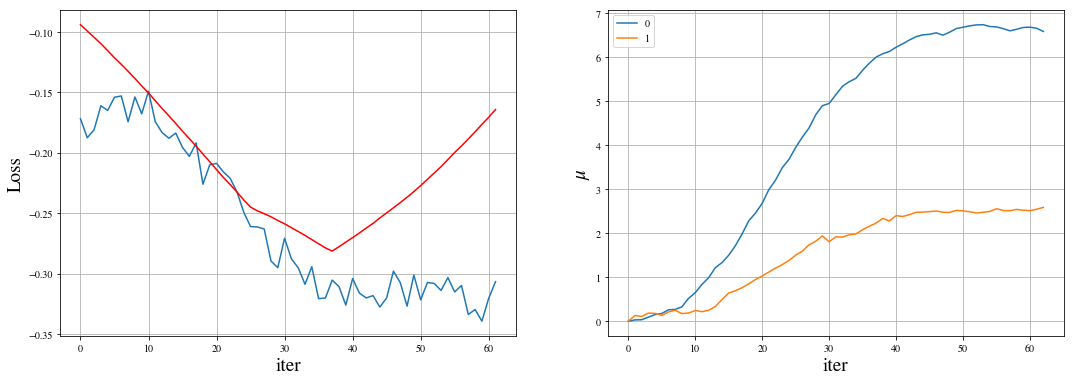

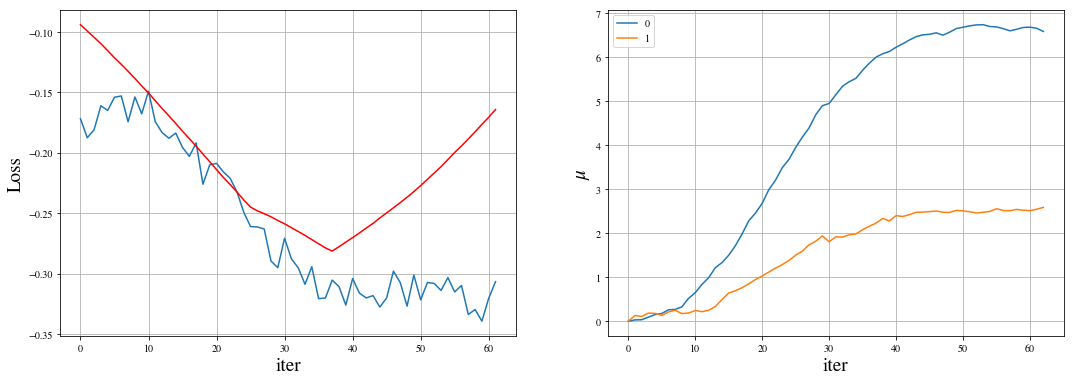

In [11]:
end_to_end_training(current_psi=torch.tensor([[0., 0.]]).float().to(device))

In [12]:
torch.__version__

'1.1.0'

'1.1.0'

In [26]:
!pip install click

     |################################| 81kB 3.8MB/s eta 0:00:011


In [27]:
ls

Untitled.ipynb  end_to_end_ffjord.py     gan_model_new.py       optimizer.py
__init__.py     ffjord/                  gan_parameters.py      prerun.py
__pycache__/    ffjord_model.py          logger.py              train.py
base_model.py   fjord_opt_testing.ipynb  optim.py
end_to_end.py   gan_model.py             optimisation_Md.ipynb


In [42]:
!export LC_ALL=C.UTF-8 && export LANG=C.UTF-8 && python test.py London --gan_type=GAN

Usage: test.py [OPTIONS] LOCATION
Try "test.py --help" for help.

Error: no such option: --gan_type


In [34]:
!python test.py

Traceback (most recent call last):
  File "test.py", line 9, in <module>
    main()
  File "/root/miniconda/lib/python3.6/site-packages/click/core.py", line 764, in __call__
    return self.main(*args, **kwargs)
  File "/root/miniconda/lib/python3.6/site-packages/click/core.py", line 696, in main
    _verify_python3_env()
  File "/root/miniconda/lib/python3.6/site-packages/click/_unicodefun.py", line 124, in _verify_python3_env
    ' mitigation steps.' + extra
RuntimeError: Click will abort further execution because Python 3 was configured to use ASCII as encoding for the environment. Consult https://click.palletsprojects.com/en/7.x/python3/ for mitigation steps.

This system supports the C.UTF-8 locale which is recommended.
You might be able to resolve your issue by exporting the
following environment variables:

    export LC_ALL=C.UTF-8
    export LANG=C.UTF-8


In [43]:
!pip install ConfigArgParse

  Stored in directory: /root/.cache/pip/wheels/aa/9c/ce/7e904dddb8c7595ffbe3409d24455bc5005852850e36011bda
Successfully built ConfigArgParse


In [37]:
import lhsmdu
torch.tensor(lhsmdu.sample(2, 100, randomSeed=np.random.randint(1e5)).T).float();

KeyboardInterrupt: 

In [38]:
!pip install pynolh

  Created wheel for pynolh: filename=pynolh-0.1-cp36-none-any.whl size=6994 sha256=0b198a493f2f9f0742ba6e894c05e9aee48fa408ab5bb4a09b94ed2bf056d49b
  Stored in directory: /root/.cache/pip/wheels/b2/21/bf/4b334928cbf1a0ec0a9ad8d8da30e9d7b5c5778b1d43920679
Successfully built pynolh


In [44]:
import pynolh

dim = 6
m, q, r = pynolh.params(dim)
conf = np.arange(q).astype(int)
remove = np.arange(dim - r, dim).astype(int)
nolh = pynolh.nolh(conf, remove)

TypeError: 'float' object cannot be interpreted as an integer

In [46]:
remove

array([5])

In [48]:
!pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp36-none-any.whl size=18178 sha256=4596c89b20e0371120864f2fb82bccf8fd88494b60fb75703034b51a2876cea6
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


In [55]:
from prd_score import compute_prd_from_embedding

In [66]:
%%time
compute_prd_from_embedding(np.random.randn(100 * 100, 5), 
                           np.random.randn(100 * 100, 5))

CPU times: user 1.85 s, sys: 4 ms, total: 1.85 s
Wall time: 1.85 s


(array([1.00000000e-10, 1.57079772e-03, 3.14160309e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        3.14160309e-03, 1.57079772e-03, 1.00000070e-10]))

array([[-0.98584357,  0.74836585,  0.53940976,  0.3892282 , -0.79110029],
       [-2.34433513,  1.38496902, -0.14806807, -0.75129732, -1.93678535],
       [-1.53118252,  1.09350768, -0.64768516,  1.17637857, -0.38943189],
       ...,
       [-0.03460099, -0.49481055,  1.27408697, -1.09548667,  2.00850729],
       [-0.75792849,  2.88618383, -0.59019566, -0.47282084,  0.42005653],
       [-1.56245914, -1.25155945, -0.70022274,  1.24436392, -0.05428615]])